In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, f_oneway, levene
from statsmodels.graphics.gofplots import qqplot

---

# Objective : 
A bike sharing company has recently faced a significant dip in its revenue and we would like to understand why. Especially as data scientists, determine the factors which are good predictors of demand with a certain level of confidence. Further on the basis of these strong predictors of demand we also need to give recommendations to the company.

# Insights : 

- Clear, working winter day is the most common day reported in the data
- The count of casual, registered and total rental bikes per hour shows a somewhat poisson distribution
- Temp, feeling temp, humidity and windspeed are also somewhat normally distributed centered around 20, 25, 60 and 13 respectively


- Insights from visual EDA : 
    - Most bikes seems to be rented in fall and the least in spring
    - There seems to be slightly more number of bikes rented on a holiday as compared to no holiday (very small difference)
    - There seems to be slightly lesser number of bikes rented on a working day (very small difference)
    - Most bikes are rented on clear days and the least on rainy days


- We cannot infer that working day has an effect on number of bikes rented (t-test pvalue is 22.6%)


- We can infer that weather has a significant effect on number of bikes rented (f-test pvalue is ~0%)
- We can infer that clear weather is linked to increase in number of bikes rented (Welch t-test pvalue ~0%)


- We can infer that season has a significant effect on number of bikes rented (f-test pvalue is ~0%)
- We can infer that summer and fall season is linked to increase in number of bikes rented (Welch t-test pvalue ~0%)


- We can infer that season has a significant effect on the weather (chisquare-test pvalue is ~0%)

# Recommendations : 

- The bike sharing company should start extensive marketing campaigns at the start of summer season and run them all the way through fall season.
- During these 2 seasons they should increase their supply of cycles, and install more pick up/drop locations to make sure that the demand is fully met.
- They should also introduce Miles Points (like flights) during these seasons to build customer loyalty and retain them for the next year as well.

# EDA

## Non Visual

In [2]:
df = pd.read_csv('bike_sharing.csv')

In [3]:
df.shape

(10886, 12)

In [4]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- No nulls found in data

In [6]:
#Changing dtype: 
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

#Coverting to categorical values for easier interpretation of data
df['season'] = df['season'].replace({1:'spring',2:'summer',3:'fall',4:'winter'})
df['holiday'] = df['holiday'].replace({1:'holiday',0:'no holiday'})
df['workingday'] = df['workingday'].replace({1:'workingday',0:'no workingday'})
df['weather'] = df['weather'].replace({1:'clear',2:'mist',3:'light rain/snow',4:'heavy rain/snow'})

In [7]:
df.describe(datetime_is_numeric=True)

,datetime,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [8]:
df.describe(include='O')

,season,holiday,workingday,weather
count,10886,10886,10886,10886
unique,4,2,2,4
top,winter,no holiday,workingday,clear
freq,2734,10575,7412,7192


- Clear, working winter day is the most common day reported in the data

## Visual EDA

### Univariate

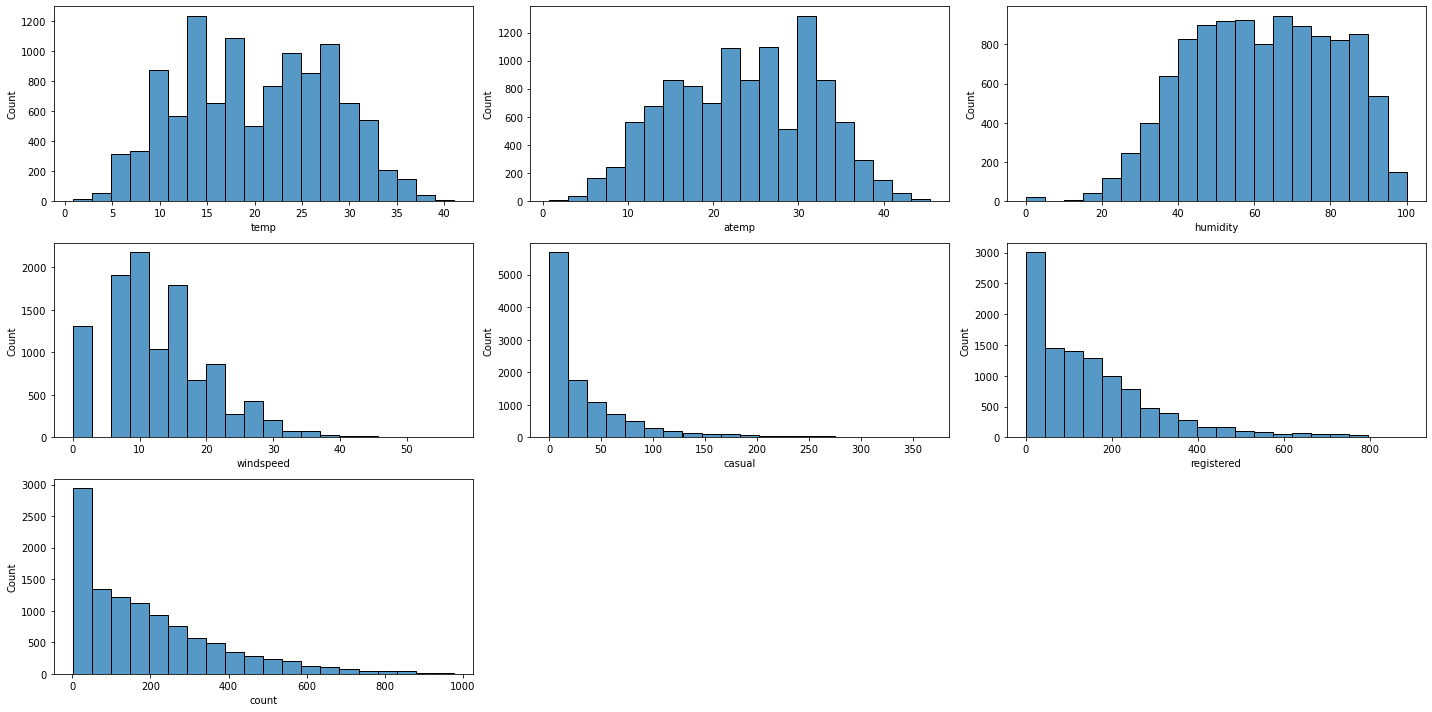

In [10]:
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['figure.autolayout'] = True
continous_variables = ['temp', 'atemp', 'humidity', 'windspeed', 'casual','registered', 'count']
for e, c in enumerate(continous_variables):
    ax = plt.subplot(3,3,e+1)
    sns.histplot(df[c],ax=ax, bins=20)

- The count of casual, registered and total rental bikes per hour shows a somewhat poisson distribution
- Temp, feeling temp, humidity and windspeed are also somewhat normally distributed centered around 20, 25, 60 and 13 respectively

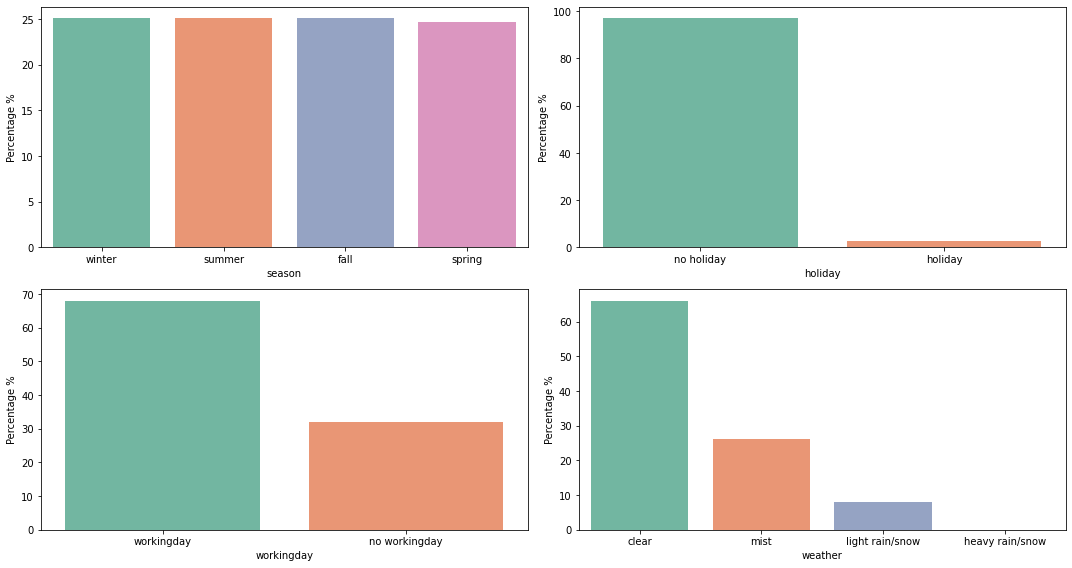

In [11]:
plt.rcParams['figure.figsize'] = (15,8)
categorical_variables = ['season','holiday','workingday','weather']
for e,c in enumerate(categorical_variables):
    ax = plt.subplot(2,2,e+1)
    data = df[c].value_counts(1) * 100
    sns.barplot(x=data.index, y=data.values, ax=ax, palette='Set2')
    ax.set_ylabel('Percentage %')
    ax.set_xlabel(c)

- We have equal data for all the 4 seasons
- We have less than 10% data from holidays (Because there are very few holidays in a year)
- Around 65% of the days are working in a year (Based on holidays + weekends)
- Around 65% of the days had clear weather, and almost 0% days had heavy rain

### Bivariate

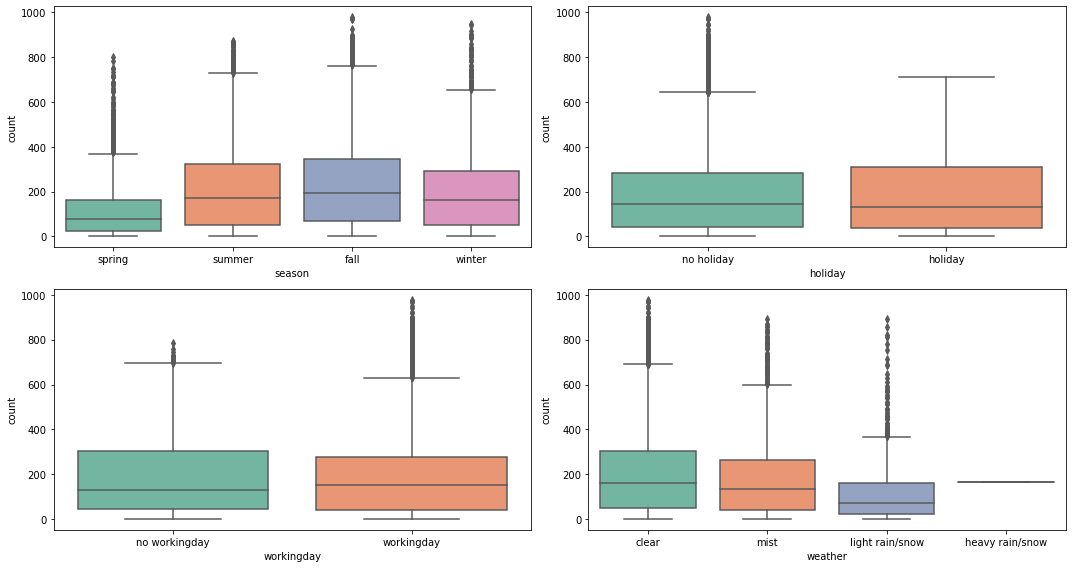

In [12]:
fig,ax = plt.subplots(2,2,figsize=(15,8))
sns.boxplot(x='season', y='count', data=df, ax=ax[0][0], palette='Set2')
sns.boxplot(x='holiday', y='count', data=df, ax=ax[0][1], palette='Set2')
sns.boxplot(x='workingday', y='count', data=df, ax=ax[1][0], palette='Set2')
sns.boxplot(x='weather', y='count', data=df, ax=ax[1][1], palette='Set2')
print()

- From the above boxplots we can say : 
    - Most bikes seems to be rented in fall and the least in spring
    - There seems to be slightly more number of bikes rented on a holiday as compared to no holiday (very small difference)
    - There seems to be slightly lesser number of bikes rented on a working day (very small difference)
    - Most bikes are rented on clear days and the least on rainy days

# Hypothesis Testing

In [13]:
df_copy = pd.read_csv('bike_sharing.csv')

## Does Working Day effects bike rentals? 

- H<sub>0</sub> : Working day has no effect on number of bikes rented
- H<sub>a</sub> : Working day has an effect on number of bikes rented
- Significance level : 5%
- Test Statistic : t-test score (2 Sample t-test)

In [14]:
bikes_on_working_day = df_copy.loc[df_copy['workingday'] == 1,'count'].values
bikes_on_non_working_day = df_copy.loc[df_copy['workingday'] == 0,'count'].values

### Checking ttest assumptions

In [15]:
# Equal Variance : Both samples need to have equal variance otherwise we will do a Welch t-test
# Null hypothesis : There is no difference of standard deviation between the samples
# Alternate hypothesis : There is a difference of standard deviation between the samples
# We can do a levene test to check this at a significance level of 5% 

levene(bikes_on_working_day, bikes_on_non_working_day)

LeveneResult(statistic=0.004972848886504472, pvalue=0.9437823280916695)

- The levene test gives a pvalue of 94% which is much higher than our significance level 
- Hence we cannot reject the null hypothesis
- Hence we cannot say that these distributions have different standard deviations

In [16]:
# We will do a 2 sample t-test to check if these two are independent or not
ttest_ind(bikes_on_working_day, bikes_on_non_working_day)

Ttest_indResult(statistic=1.2096277376026694, pvalue=0.22644804226361348)

- We get a t-test score of 1.2
- Our pvalue is 22.6% which is much higher than our significance level of 5%
- We cannot reject the H<sub>0</sub>
- We cannot infer that working day has an effect on number of bikes rented

----

## Does Weather effects bike rentals?

In [17]:
df_copy['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

- There is only 1 data point for weather type 4 ie (Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)
- We will do ANOVA on the rest 3 weather types only

- H<sub>0</sub> : Weather has no effect on number of bikes rented
- H<sub>a</sub> : Weather has an effect on number of bikes rented
- Significance level : 5%
- Test Statistic : f-statistic (ANOVA)

In [18]:
bikes_on_weather_type_1 = df_copy.loc[df_copy['weather'] == 1,'count'].values
bikes_on_weather_type_2 = df_copy.loc[df_copy['weather'] == 2,'count'].values
bikes_on_weather_type_3 = df_copy.loc[df_copy['weather'] == 3,'count'].values

### Checking ANOVA assumptions

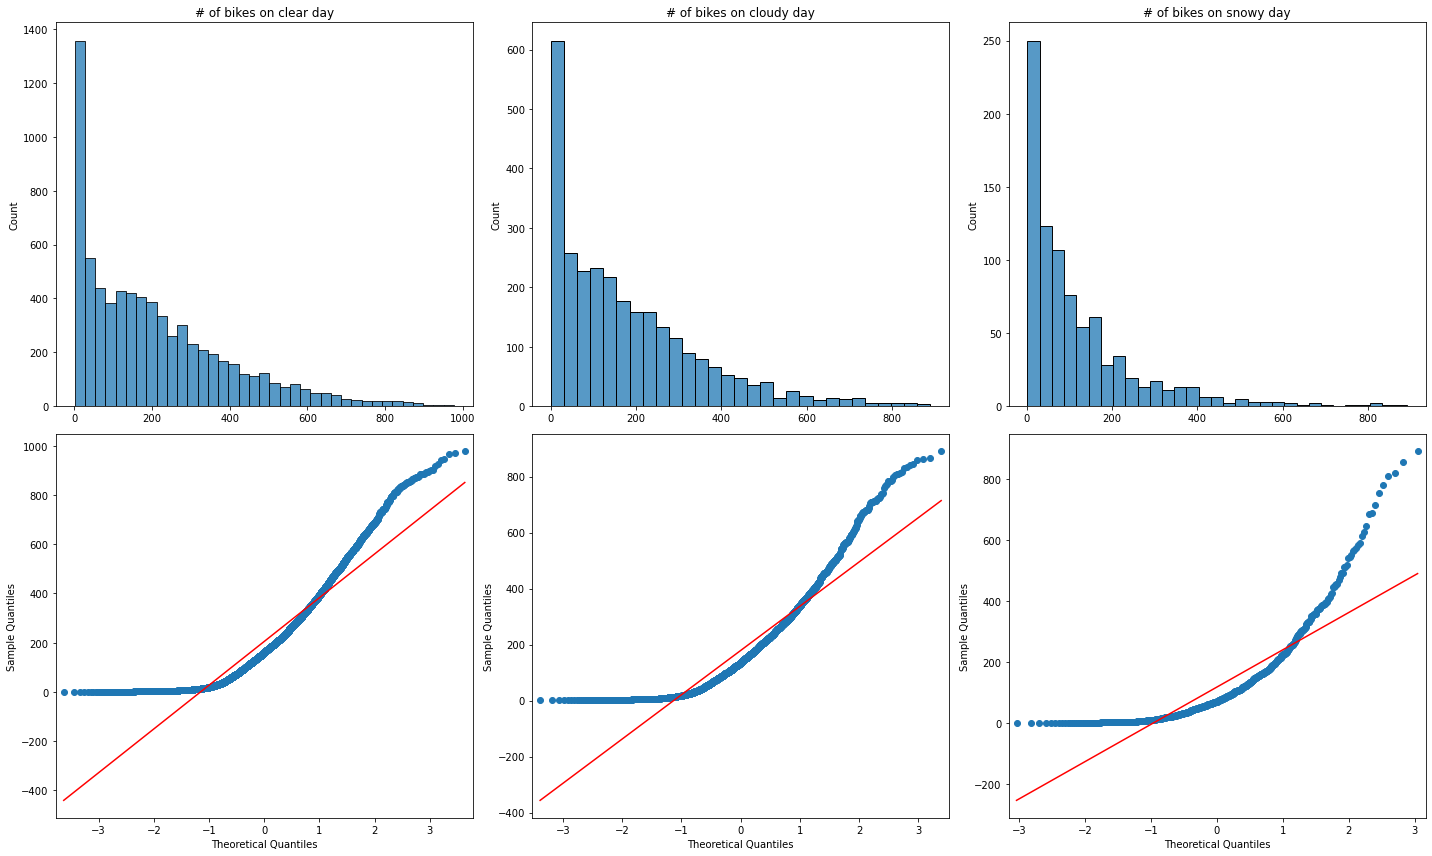

In [19]:
# Normal Assumption : The sample distributions should be normally distributed
fig,ax = plt.subplots(2,3,figsize=(20,12))
sns.histplot(bikes_on_weather_type_1,ax=ax[0][0])
sns.histplot(bikes_on_weather_type_2,ax=ax[0][1])
sns.histplot(bikes_on_weather_type_3,ax=ax[0][2])
ax[0][0].set_title('# of bikes on clear day')
ax[0][1].set_title('# of bikes on cloudy day')
ax[0][2].set_title('# of bikes on snowy day')

qqplot(bikes_on_weather_type_1,line='r',ax=ax[1][0])
qqplot(bikes_on_weather_type_2,line='r',ax=ax[1][1])
qqplot(bikes_on_weather_type_3,line='r',ax=ax[1][2])
plt.show()

- We can see from above graphs that none of the distributions are normal

In [20]:
# Equal Variance Assumption : The sample distribution should have equal variance
# Null hypothesis : There is no difference of standard deviation between the samples
# Alternate hypothesis : There is a difference of standard deviation between the samples
# We can do a levene test to check this at a significance level of 5% 

levene(bikes_on_weather_type_1, bikes_on_weather_type_2, bikes_on_weather_type_3)

LeveneResult(statistic=81.67574924435011, pvalue=6.198278710731511e-36)

- The levene test gives a pvalue of ~0% which is much less than our significance level 
- Hence we can reject the null hypothesis
- Hence we can say that these distributions have different standard deviations

In [21]:
# We now do a one way ANOVA to check the difference of means between the samples
f_oneway(bikes_on_weather_type_1, bikes_on_weather_type_2, bikes_on_weather_type_3)

F_onewayResult(statistic=98.28356881946706, pvalue=4.976448509904196e-43)

- We get a fstat of 98.3
- Our pvalue is ~0% which is much lower than our significance level of 5%
- We reject the H<sub>0</sub>
- We can infer that weather has a significant effect on number of bikes rented

## Are there more bikes rented on clear days? 

- H<sub>0</sub> : Clear weather has no effect on number of bikes rented
- H<sub>a</sub> : Clear weather increases the number of bikes rented
- Significance level : 5%
- Test Statistic :  t-test score (2 sample t-test)

In [22]:
bikes_on_weather_type_2_and_3 = np.concatenate((bikes_on_weather_type_2, bikes_on_weather_type_3))

In [23]:
# Checking ttest assumptions
# Equal Variance Assumption : The sample distribution should have equal variance
# Null hypothesis : There is no difference of standard deviation between the samples
# Alternate hypothesis : There is a difference of standard deviation between the samples
# We can do a levene test to check this at a significance level of 5% 

levene(bikes_on_weather_type_1, bikes_on_weather_type_2_and_3)

LeveneResult(statistic=87.13479803756756, pvalue=1.210545470625517e-20)

- The levene test gives a pvalue of ~0% which is much less than our significance level 
- Hence we can reject the null hypothesis
- Hence we can say that these distributions have different standard deviations
- Hence we will do a Welch t-test instead here

In [24]:
# We will do a 2 sample Welch t-test to check if these two are independent or not
ttest_ind(bikes_on_weather_type_1, bikes_on_weather_type_2_and_3, alternative='greater', equal_var=False)

Ttest_indResult(statistic=11.5340767638041, pvalue=7.540763883724984e-31)

- We get a t-test score of 11
- Our pvalue is ~0% which is much lower than our significance level of 5%
- We can reject the H<sub>0</sub>
- We can infer that clear weather is linked to increase in number of bikes rented

----

## Does season effects bike rentals?

In [25]:
df_copy['season'].value_counts()

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64

- H<sub>0</sub> : Season has no effect on number of bikes rented
- H<sub>a</sub> : Season has an effect on number of bikes rented
- Significance level : 5%
- Test Statistic : f-statistic (ANOVA)

In [26]:
bikes_on_season_type_1 = df_copy.loc[df_copy['season'] == 1,'count'].values
bikes_on_season_type_2 = df_copy.loc[df_copy['season'] == 2,'count'].values
bikes_on_season_type_3 = df_copy.loc[df_copy['season'] == 3,'count'].values
bikes_on_season_type_4 = df_copy.loc[df_copy['season'] == 4,'count'].values

### Checking ANOVA assumptions

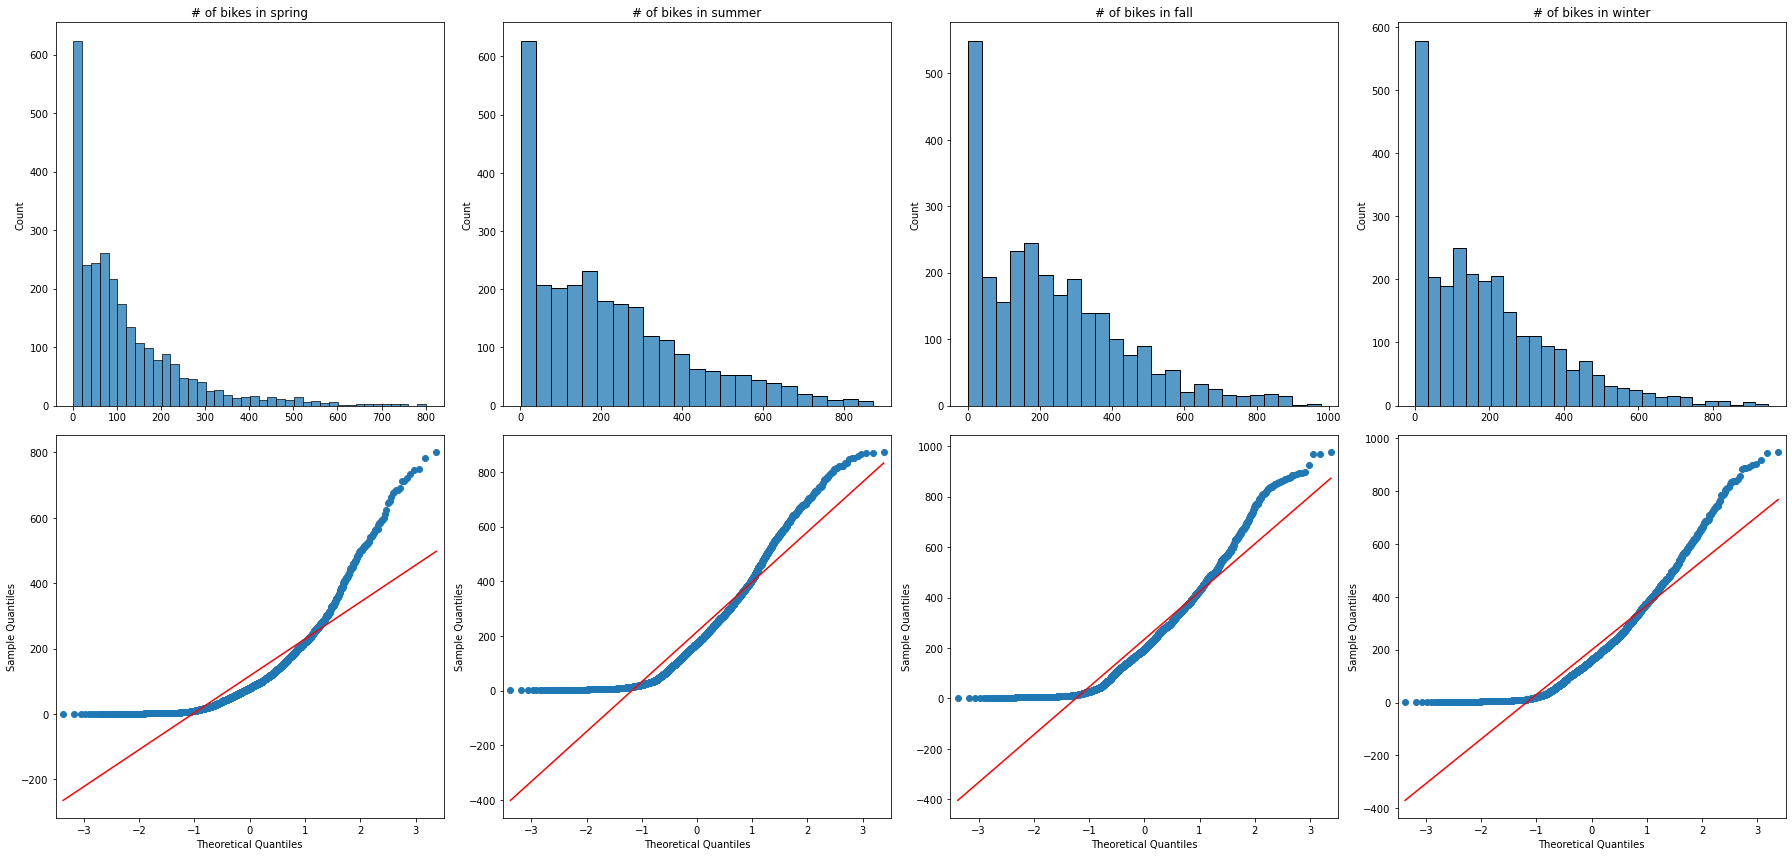

In [27]:
# Normal Assumption : The sample distributions should be normally distributed
fig,ax = plt.subplots(2,4,figsize=(25,12))
sns.histplot(bikes_on_season_type_1,ax=ax[0][0])
sns.histplot(bikes_on_season_type_2,ax=ax[0][1])
sns.histplot(bikes_on_season_type_3,ax=ax[0][2])
sns.histplot(bikes_on_season_type_4,ax=ax[0][3])
ax[0][0].set_title('# of bikes in spring')
ax[0][1].set_title('# of bikes in summer')
ax[0][2].set_title('# of bikes in fall')
ax[0][3].set_title('# of bikes in winter')

qqplot(bikes_on_season_type_1,line='r',ax=ax[1][0])
qqplot(bikes_on_season_type_2,line='r',ax=ax[1][1])
qqplot(bikes_on_season_type_3,line='r',ax=ax[1][2])
qqplot(bikes_on_season_type_4,line='r',ax=ax[1][3])

plt.show()

- We can see from above graphs that none of the distributions are normal

In [28]:
# Equal Variance Assumption : The sample distribution should have equal variance
# Null hypothesis : There is no difference of standard deviation between the samples
# Alternate hypothesis : There is a difference of standard deviation between the samples
# We can do a levene test to check this at a significance level of 5% 

levene(bikes_on_season_type_1, bikes_on_season_type_2, bikes_on_season_type_3, bikes_on_season_type_4)

LeveneResult(statistic=187.7706624026276, pvalue=1.0147116860043298e-118)

- The levene test gives a pvalue of ~0% which is much less than our significance level 
- Hence we can reject the null hypothesis
- Hence we can say that these distributions have different standard deviations

In [29]:
# We will now do one way ANOVA to check difference between means
f_oneway(bikes_on_season_type_1, bikes_on_season_type_2, bikes_on_season_type_3, bikes_on_season_type_4)

F_onewayResult(statistic=236.94671081032106, pvalue=6.164843386499654e-149)

- We get a fstat of 236.9
- Our pvalue is ~0% which is much lower than our significance level of 5%
- We reject the H<sub>0</sub>
- We can infer that season has a significant effect on number of bikes rented

## Are there more bikes rented in summer and fall? 

- H<sub>0</sub> : Summer and Fall season has no effect on number of bikes rented
- H<sub>a</sub> : Summer and Fall season increases the number of bikes rented
- Significance level : 5%
- Test Statistic : t-test score (2 sample t-test)

In [30]:
bikes_on_season_type_2_and_3 = np.concatenate((bikes_on_season_type_2, bikes_on_season_type_3))
bikes_on_season_type_1_and_4 = np.concatenate((bikes_on_season_type_1, bikes_on_season_type_4))

In [31]:
# Checking ttest assumptions
# Equal Variance Assumption : The sample distribution should have equal variance
# Null hypothesis : There is no difference of standard deviation between the samples
# Alternate hypothesis : There is a difference of standard deviation between the samples
# We can do a levene test to check this at a significance level of 5% 

levene(bikes_on_season_type_2_and_3, bikes_on_season_type_1_and_4)

LeveneResult(statistic=237.21717358575066, pvalue=5.74764555857786e-53)

- The levene test gives a pvalue of ~0% which is much less than our significance level 
- Hence we can reject the null hypothesis
- Hence we can say that these distributions have different standard deviations
- Hence we will do a Welch t-test instead here

In [32]:
# We will do a 2 sample Welch t-test to check if these two are independent or not
ttest_ind(bikes_on_season_type_2_and_3, bikes_on_season_type_1_and_4, alternative='greater', equal_var=False)

Ttest_indResult(statistic=19.589523172181725, pvalue=2.9605129625749147e-84)

- We get a t-test score of 19.5
- Our pvalue is ~0% which is much lower than our significance level of 5%
- We can reject the H<sub>0</sub>
- We can infer that summer and fall season is linked to increase in number of bikes rented

---

## Is weather dependent on season?

In [33]:
df_copy['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

- Again dropping the weather type 4 before doing the test
- In chi2 test we also require atleast 5 samples in each category

- H<sub>0</sub> : Season has no effect on the weather
- H<sub>a</sub> : Season has an effect on the weather
- Significance level : 5%
- Test Statistic : chi-statistic

In [34]:
df_copy = df_copy[df_copy['weather'] != 4]
df = df[df['weather'] != 'heavy rain/snow']

<AxesSubplot:xlabel='season', ylabel='weather'>

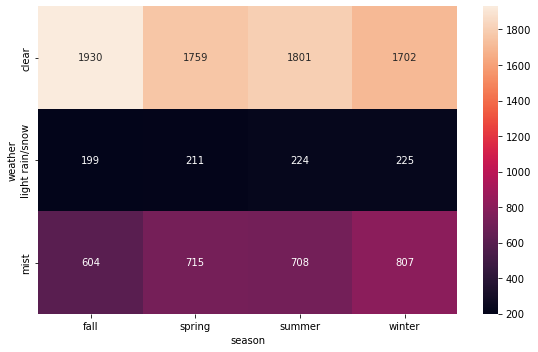

In [35]:
#Lets look at a crosstab between weather and season
plt.rcParams['figure.figsize'] = (8,5)
sns.heatmap(pd.crosstab(df['weather'], df['season']),annot=True,fmt='d')

In [36]:
# We will do a chi sqaure test to see if these two features are dependent or not
chi2_contingency(pd.crosstab(df_copy['weather'], df_copy['season']))

(46.101457310732485,
 2.8260014509929403e-08,
 6,
 array([[1774.04869086, 1805.76352779, 1805.76352779, 1806.42425356],
        [ 699.06201194,  711.55920992,  711.55920992,  711.81956821],
        [ 211.8892972 ,  215.67726229,  215.67726229,  215.75617823]]))

- We get a chisquare-stat of 46.1
- Our pvalue is ~0% which is much lower than our significance level of 5%
- We reject the H<sub>0</sub>
- We can infer that season has a significant effect on the weather

---